# **How Batch Normalization affect the performance of the model?**
# In this notebook, we will see how effective it is to use *Batch Normalization* in neural networks.We will implement Batch Normalization for a simple neural network using PyTorch.

# **STEP 1.** Create a neural network with at least one hidden layer.

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [10]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.l2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.l1(x)
        x = torch.tanh(x)
        x = self.l2(x)

        return x


# **Step 2:** Implement Batch Normalization layer

In [11]:

class BatchNorm(nn.Module):
    def __init__(self, num_features, momentum=0.1):
        super(BatchNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))
        self.momentum = momentum
        self.running_mean = None
        self.running_var = None

    def forward(self, x):
        if self.training:
          mu = torch.mean(x, 0)
          var = torch.mean((x - mu) ** 2, 0)

          if self.running_mean is None:
            self.running_mean = torch.zeros_like(mu)
          if self.running_var is None:
            self.running_var = torch.zeros_like(var)

          self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mu
          self.running_var = (1 - self.momentum) * self.running_var + self.momentum * var
        else:
          mu = self.running_mean
          var = self.running_var

        x = (x - mu) / torch.sqrt(var + 10e-8)
        x = self.gamma * x + self.beta

        return x



In [12]:
# Define a neural network with BN
class NetBN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NetBN, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.bn1 = BatchNorm(hidden_size)
        self.l2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.l1(x)
        x = self.bn1(x)
        x = torch.tanh(x)
        x = self.l2(x)

        return x

# **Step 3:** Training the network

In [13]:
input_size = 784
hidden_size = 100
num_classes = 10
batch_size = 100
num_epochs = 5

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_without_bn = Net(input_size, hidden_size, num_classes).to(device)
model_with_bn = NetBN(input_size, hidden_size, num_classes).to(device)

without_bn_hist = []
with_bn_hist = []


criterion = nn.CrossEntropyLoss()

# Init 2 optimizers with the same learning rate for training with and without BN
optimizer_without_bn = torch.optim.Adam(model_without_bn.parameters(), lr=0.01)
optimizer_with_bn = torch.optim.Adam(model_with_bn.parameters(), lr=0.01)

def train(model, optimizer, criterion):
    history = []

    model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 28 * 28).to(device)
        labels = labels.to(device)


        # should define loss that is equal to the loss of the current epoch
        optimizer.zero_grad()
        loss = criterion(model(images), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss/100:.4f}')
            history.append(running_loss)
            running_loss = 0.0

    return history

for epoch in range(num_epochs):
    without_bn_hist.extend(train(model_without_bn, optimizer_without_bn, criterion))
    print("Training without Batch Normalization finished for epoch", epoch+1)

    with_bn_hist.extend(train(model_with_bn, optimizer_with_bn, criterion))
    print("Training with Batch Normalization finished for epoch", epoch+1)

Epoch [1/5], Step [100/600], Loss: 1.4000
Epoch [1/5], Step [200/600], Loss: 0.7359
Epoch [1/5], Step [300/600], Loss: 0.6572
Epoch [1/5], Step [400/600], Loss: 0.6208
Epoch [1/5], Step [500/600], Loss: 0.5813
Epoch [1/5], Step [600/600], Loss: 0.5526
Training without Batch Normalization finished for epoch 1
Epoch [1/5], Step [100/600], Loss: 0.4329
Epoch [1/5], Step [200/600], Loss: 0.2832
Epoch [1/5], Step [300/600], Loss: 0.2370
Epoch [1/5], Step [400/600], Loss: 0.2142
Epoch [1/5], Step [500/600], Loss: 0.1907
Epoch [1/5], Step [600/600], Loss: 0.1767
Training with Batch Normalization finished for epoch 1
Epoch [2/5], Step [100/600], Loss: 0.5553
Epoch [2/5], Step [200/600], Loss: 0.5639
Epoch [2/5], Step [300/600], Loss: 0.5143
Epoch [2/5], Step [400/600], Loss: 0.5326
Epoch [2/5], Step [500/600], Loss: 0.5490
Epoch [2/5], Step [600/600], Loss: 0.5448
Training without Batch Normalization finished for epoch 2
Epoch [2/5], Step [100/600], Loss: 0.1285
Epoch [2/5], Step [200/600], Lo

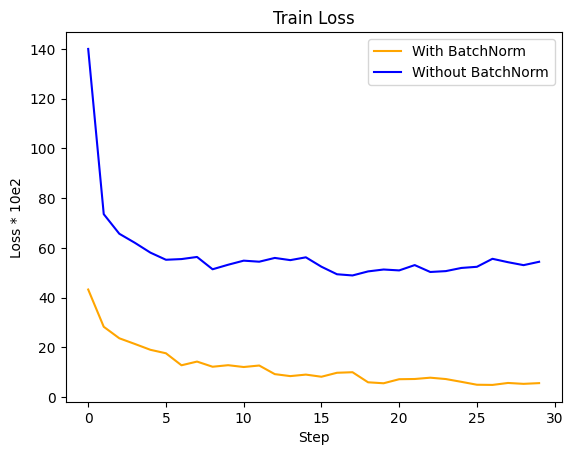

In [14]:
import matplotlib.pyplot as plt
import numpy as np

num_steps = np.arange(len(with_bn_hist))
plt.title("Train Loss")
plt.xlabel("Step")
plt.ylabel("Loss * 10e2")
plt.plot(num_steps, with_bn_hist, color="orange", label="With BatchNorm")
plt.plot(num_steps, without_bn_hist, color="blue", label="Without BatchNorm")
plt.legend()
plt.show()

In [21]:
import pandas as pd

test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)


def top_one_error(logits, y_true):
    pred_proba = torch.sigmoid(logits)
    y_pred = torch.argmax(pred_proba, -1)
    res = torch.sum((y_pred == y_true) * 1.0) / len(y_true)

    return res.item()

def top_five_error(logits, y_true):
    pred_proba = torch.sigmoid(logits)
    top_five = torch.argsort(pred_proba, -1, descending=True)[:, :5]
    res = torch.sum((top_five == y_true.view(-1, 1)).any(-1) * 1.0) / len(y_true)

    return res.item()



images, labels = next(iter(test_loader))
images = images.view(-1, 28 * 28).to(device)
labels = labels.to(device)

model_with_bn.train(False)
model_without_bn.train(False)

results = [[top_one_error(model_without_bn(images), labels),
            top_five_error(model_without_bn(images), labels)],
             [top_one_error(model_with_bn(images), labels),
              top_five_error(model_with_bn(images), labels)]]

df = pd.DataFrame(results, index = ["Without Norm", "With BatchNorm"], columns = ["Top-1", "Top-5"])
df

,Top-1,Top-5
Without Norm,0.89,1.0
With BatchNorm,0.97,1.0


# **Do the same for Layer Norm and compare the results**

In [17]:
class LayerNorm(nn.Module):
    def __init__(self, num_features):
        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))

    def forward(self, x):
        mu = torch.mean(x, -1, keepdims=True)
        var = torch.mean((x - mu) ** 2, -1, keepdims=True)
        x = (x - mu) / torch.sqrt(var + 10e-8)
        x = self.gamma * x + self.beta

        return x


class NetLN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NetLN, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.ln1 = LayerNorm(hidden_size)
        self.l2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.l1(x)
        x = self.ln1(x)
        x = torch.tanh(x)
        x = self.l2(x)

        return x


In [18]:
model_with_ln = NetLN(input_size, hidden_size, num_classes)
optimizer_with_ln = torch.optim.Adam(model_with_ln.parameters(), lr=0.01)
with_ln_hist = []

for epoch in range(num_epochs):
    with_ln_hist.extend(train(model_with_ln, optimizer_with_ln, criterion))
    print("Training with Layer Normalization finished for epoch", epoch+1)

Epoch [1/5], Step [100/600], Loss: 0.9712
Epoch [1/5], Step [200/600], Loss: 0.3793
Epoch [1/5], Step [300/600], Loss: 0.2829
Epoch [1/5], Step [400/600], Loss: 0.2621
Epoch [1/5], Step [500/600], Loss: 0.2489
Epoch [1/5], Step [600/600], Loss: 0.2299
Training with Layer Normalization finished for epoch 1
Epoch [2/5], Step [100/600], Loss: 0.1866
Epoch [2/5], Step [200/600], Loss: 0.1911
Epoch [2/5], Step [300/600], Loss: 0.1737
Epoch [2/5], Step [400/600], Loss: 0.1866
Epoch [2/5], Step [500/600], Loss: 0.1585
Epoch [2/5], Step [600/600], Loss: 0.1574
Training with Layer Normalization finished for epoch 2
Epoch [3/5], Step [100/600], Loss: 0.1489
Epoch [3/5], Step [200/600], Loss: 0.1408
Epoch [3/5], Step [300/600], Loss: 0.1388
Epoch [3/5], Step [400/600], Loss: 0.1346
Epoch [3/5], Step [500/600], Loss: 0.1371
Epoch [3/5], Step [600/600], Loss: 0.1279
Training with Layer Normalization finished for epoch 3
Epoch [4/5], Step [100/600], Loss: 0.1136
Epoch [4/5], Step [200/600], Loss: 0.

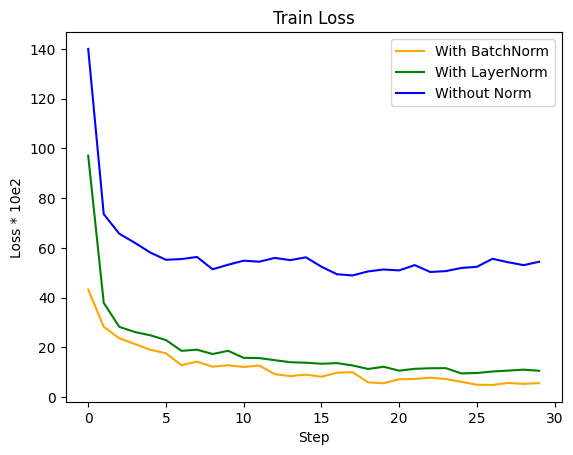

In [20]:
plt.title("Train Loss")
plt.xlabel("Step")
plt.ylabel("Loss * 10e2")
plt.plot(num_steps, with_bn_hist, color="orange", label="With BatchNorm")
plt.plot(num_steps, with_ln_hist, color="green", label="With LayerNorm")
plt.plot(num_steps, without_bn_hist, color="blue", label="Without Norm")
plt.legend()
plt.show()

In [22]:
model_with_ln.train(False)
df.loc["With LayerNorm", :] = [top_one_error(model_with_ln(images), labels),
            top_five_error(model_with_ln(images), labels)]
df

,Top-1,Top-5
Without Norm,0.89,1.0
With BatchNorm,0.97,1.0
With LayerNorm,0.98,1.0
